## Step 8 - Fairness 

Goal of this step : Assess the **fairness** of your own model with respect to the protected attribute. 
Use a **statistical test** for the following two fairness definitions: **Statistical Parity** and **Conditional Statistical Parity**.

- **Statistical parity :** a classifier satisfies the statistical parity if subjects in both protecte and unprotected groups have equal probabilities of being assigned to the prositive predicted class. In other words, the applicants should have an equivalent opportunity to obtain a good test score, regardless of its gender or its ethnic group. We should have : 
$$P(d=1|Gender=M) = P(d=1|Gender=F)$$

- **Conditional Statistical parity :** if subjects in both protected and unprotected groups have equal probability of being assigned to the positive predicted class, controlling for a legitimate factors (or features) $L \in X$. For example : 
$$P(d=1|Gender=M, L=I) = P(d=1|Gender=F, L=I)$$

**How to build groups ?** For credit scoring applications for example, groups gather applicants with similar risk profiles: Determined through unsupervised clustering methods (K-Means) or using an exogenous classification (Basel classification). We could do the same for students.

**How to choose the number of groups ?** To keep in mind that the larger the number of sub-groups, then : 
- The more homogenous the sub‐groups are (cleaner test)
- The more likely at least one sub‐group is found to be unfair
- The smaller the number of individuals in each sub‐group

In [28]:
# Import statements 
import joblib
import numpy as np
import pandas as pd 
from scipy.stats import chi2
from sklearn.model_selection import train_test_split

In [29]:
# Load dataset
df = pd.read_csv('../Dataset/df_processed.csv')
X = df.drop('Grade', axis=1).copy()
y = df['Grade'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Load the model from the file
model_filename = '../Models/blackbox_model.pkl'
blackbox_model = joblib.load(model_filename)
y_pred_blackbox_test = blackbox_model.predict(X_test)
y_pred_blackbox_train = blackbox_model.predict(X_train)

# Add prediction to features dataframe
df_test_results = X_test.copy()
df_test_results['y_pred'] = y_pred_blackbox_test
df_test_results.head()

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,School_Bus,WklyStudyHours,y_pred
25876,male,group B,some college,free/reduced,0,married,sometimes,1,1,0,Between 5-10 hours,0
26259,female,group C,some high school,free/reduced,0,divorced,sometimes,0,1,0,Less than 5 hours,0
11278,male,group B,some high school,free/reduced,0,single,sometimes,1,1,1,More than 10 hours,0
26508,female,group A,high school,standard,0,single,never,1,1,1,Between 5-10 hours,0
23734,female,group C,some college,standard,0,married,regularly,0,1,0,More than 10 hours,0


### 1. Assess model fairness using statistical parity definition of fairness 

The independence assumption for **statistical parity** is :  $H_0 : \hat{Y}⫫G$.
The corresponding chi-squared test statistic satisfies : 

$$\chi^2_{SP} = \sum_j\sum_k\frac{(E(n_{+jk})-n_{+jk})^2}{E(n_{+jk})}$$

Under the null hypothesis, $\chi^2_{SP}$ has one degree of freedom.

In [47]:
def count_gender_type(df):
    df_male = df[df['Gender'] == 'male']
    df_female = df[df['Gender'] == 'female']
    n1m = df_male[df_male['y_pred']==1].shape[0]
    n0m = df_male[df_male['y_pred']==0].shape[0]
    n1f = df_female[df_female['y_pred']==1].shape[0]
    n0f = df_female[df_female['y_pred']==0].shape[0]
    return n1f, n0f, n1m, n0m

def compute_expectations(df):
    n1f, n0f, n1m, n0m = count_gender_type(df)
    n = df.shape[0]
    nf = n1f+n0f
    nm = n1m+n0m
    n1 = n1f+n1m
    n0 = n0f+n0m

    E1f = nf*n1/n
    E0f = n0f*n0/n
    
    E1m = nm*n1/n
    E0m = nm*n0/n
    return E1f, E0f, E1m, E0m

def compute_test_statistic(df): 
    n1f, n0f, n1m, n0m = count_gender_type(df)
    E1f, E0f, E1m, E0m = compute_expectations(df)
    chi2 = (n1f - E1f)**2 / E1f + (n0f - E0f)**2 / E0f + (n1m - E1m)**2 / E1m + (n0m - E0m)**2 / E0m 
    return chi2

n1f, n0f, n1m, n0m = count_gender_type(df_test_results)
E1f, E0f, E1m, E0m = compute_expectations(df_test_results)
chi2 = compute_test_statistic(df_test_results)

print('total students : ', df_test_results.shape[0])
print("Total 1 y_pred : ", n1f+n1m)
print("Total 0 y_pred : ", n0f+n0m)
print("Total women : ", n1f+n0f)
print("Total male : ", n1m+n0m)
print('\n')

print("n1f:", n1f)
print("n0f:", n0f)
print("n1m:", n1m)
print("n0m:", n0m)
print('\n')

print("E1f :", np.round(E1f, 2))
print("E0f :", np.round(E0f, 2))
print("E1m :", np.round(E1m, 2))
print("E0m :", np.round(E0m, 2))

print('\n')
print("Test statistic value : ", chi2)

total students :  9193
Total 1 y_pred :  858
Total 0 y_pred :  8335
Total women :  4612
Total male :  4581


n1f: 620
n0f: 3992
n1m: 238
n0m: 4343


E1f : 430.45
E0f : 3619.42
E1m : 427.55
E0m : 4153.45


Test statistic value :  214.51396289073045


We obtain $\chi^2_{SP} = 214.51$, we then reject this hypothesis and consider that the model is biaised regarding gender, from the statistical parity definition.

Let's do the same for ethnic groups now.

In [48]:
df_test_results.EthnicGroup.value_counts()

EthnicGroup
group C    3402
group D    2189
group B    1732
group E    1238
group A     632
Name: count, dtype: int64

In [52]:
def count_EthnicGroup_type(df):

    df_A = df[df['EthnicGroup'] == 'group A']
    df_B = df[df['EthnicGroup'] == 'group B']
    df_C = df[df['EthnicGroup'] == 'group C']
    df_D = df[df['EthnicGroup'] == 'group D']
    df_E = df[df['EthnicGroup'] == 'group E']

    n1A = df_A[df_A['y_pred']==1].shape[0]
    n1B = df_B[df_B['y_pred']==1].shape[0]
    n1C = df_C[df_C['y_pred']==1].shape[0]
    n1D = df_D[df_D['y_pred']==1].shape[0]
    n1E = df_E[df_E['y_pred']==1].shape[0]

    n0A = df_A[df_A['y_pred']==0].shape[0]
    n0B = df_B[df_B['y_pred']==0].shape[0]
    n0C = df_C[df_C['y_pred']==0].shape[0]
    n0D = df_D[df_D['y_pred']==0].shape[0]
    n0E = df_E[df_E['y_pred']==0].shape[0]

    return n1A, n1B, n1C, n1D, n1E, n0A, n0B, n0C, n0D, n0E

n1A, n1B, n1C, n1D, n1E, n0A, n0B, n0C, n0D, n0E = count_EthnicGroup_type(df_test_results)

def compute_expectations_EthnicGroup(df):
    n1A, n1B, n1C, n1D, n1E, n0A, n0B, n0C, n0D, n0E = count_EthnicGroup_type(df)
    n = df.shape[0]

    nA = n1A+n0A
    nB = n1B+n0B
    nC = n1C+n0C
    nD = n1D+n0D
    nE = n1E+n0E

    n1 = n1A+n1B+n1C+n1D+n1E
    n0 = n0A+n0B+n0C+n0D+n0E

    E1A = nA*n1/n
    E1B = nB*n1/n
    E1C = nC*n1/n
    E1D = nD*n1/n
    E1E = nE*n1/n

    E0A = nA*n0/n
    E0B = nB*n0/n
    E0C = nC*n0/n
    E0D = nD*n0/n
    E0E = nE*n0/n

    return E1A, E1B, E1C, E1D, E1E, E0A, E0B, E0C, E0D, E0E

def compute_test_statistic_ethnicgroup(df): 
    n1A, n1B, n1C, n1D, n1E, n0A, n0B, n0C, n0D, n0E = count_EthnicGroup_type(df)
    E1A, E1B, E1C, E1D, E1E, E0A, E0B, E0C, E0D, E0E = compute_expectations_EthnicGroup(df)

    termA1 = (n1A - E1A)**2 / E1A
    termB1 = (n1B - E1B)**2 / E1B
    termC1 = (n1C - E1C)**2 / E1C
    termD1 = (n1D - E1D)**2 / E1D
    termE1 = (n1E - E1E)**2 / E1E

    termA0 = (n0A - E0A)**2 / E0A
    termB0 = (n0B - E0B)**2 / E0B
    termC0 = (n0C - E0C)**2 / E0C
    termD0 = (n0D - E0D)**2 / E0D
    termE0 = (n0E - E0E)**2 / E0E
 
    chi2 = termA1 + termB1 + termC1 + termD1 + termE1 + termA0 + termB0 + termC0 + termD0 + termE0
    return chi2

n1f, n0f, n1m, n0m = count_gender_type(df_test_results)
E1f, E0f, E1m, E0m = compute_expectations(df_test_results)

n1A, n1B, n1C, n1D, n1E, n0A, n0B, n0C, n0D, n0E = count_EthnicGroup_type(df_test_results)
E1A, E1B, E1C, E1D, E1E, E0A, E0B, E0C, E0D, E0E = compute_expectations_EthnicGroup(df_test_results)
chi2 = compute_test_statistic_ethnicgroup(df_test_results)

print('total students : ', df_test_results.shape[0])
print("Total 1 y_pred : ", n1f+n1m)
print("Total 0 y_pred : ", n0f+n0m)
print("Total group A : ", n1A+n0A)
print("Total group B : ", n1B+n0B)
print("Total group C : ", n1C+n0C)
print("Total group D : ", n1D+n0D)
print("Total group E : ", n1E+n0E)
print('\n')

print('n1A:', n1A)
print('n1B:', n1B)
print('n1C:', n1C)
print('n1D:', n1D)
print('n1E:', n1E)

print('\n')

print('n0A:', n0A)
print('n0B:', n0B)
print('n0C:', n0C)
print('n0D:', n0D)
print('n0E:', n0E)


total students :  9193
Total 1 y_pred :  858
Total 0 y_pred :  8335
Total group A :  632
Total group B :  1732
Total group C :  3402
Total group D :  2189
Total group E :  1238


n1A: 35
n1B: 51
n1C: 168
n1D: 269
n1E: 335


n0A: 597
n0B: 1681
n0C: 3234
n0D: 1920
n0E: 903


In [53]:
print('\n')

print('E1A:', np.round(E1A, 2))
print('E1B:', np.round(E1B, 2))
print('E1C:', np.round(E1C, 2))
print('E1D:', np.round(E1D, 2))
print('E1E:', np.round(E1E, 2))
print('\n')

print('E0A:', np.round(E0A, 2))
print('E0B:', np.round(E0B, 2))
print('E0C:', np.round(E0C, 2))
print('E0D:', np.round(E0D, 2))
print('E0E:', np.round(E0E, 2))

print('\n')
print("Test statistic value : ", chi2)



E1A: 58.99
E1B: 161.65
E1C: 317.52
E1D: 204.3
E1E: 115.54


E0A: 573.01
E0B: 1570.35
E0C: 3084.48
E0D: 1984.7
E0E: 1122.46


Test statistic value :  654.2634251744396


We obtain $\chi^2_{SP} = 654.26$  , we then reject this hypothesis and consider that the model is biaised regarding gender, from the statistical parity definition.

### 2. Assess model fairness using conditional statistical parity definition of fairness 

The independence assumption for **Conditional statistical parity** is :  $H_0 : (\hat{Y}⫫G)|X $  . 
                                
For X partitioned in S subgroups, the test statistic statified is : 

$$\chi^2_{CSP} = \sum_{s=1}^S \chi^2_{SP}(s)$$

where each component of the sum denotes the test statistic obtained for the subgroup s. Under the null hypothesis, this test statistic has S degree of freedom.

In [57]:
df_test_results.columns

Index(['Gender', 'EthnicGroup', 'ParentEduc', 'LunchType', 'TestPrep',
       'ParentMaritalStatus', 'PracticeSport', 'IsFirstChild', 'NrSiblings',
       'School_Bus', 'WklyStudyHours', 'y_pred'],
      dtype='object')

First step, create the groups.

In [78]:
from sklearn.cluster import KMeans

# Assuming X is your feature matrix (without the target variable)
X = df_test_results.drop(columns=['y_pred'])  # Replace 'target_variable' with the actual name of your target variable

# Apply a numerical mapping for categorical columns
categorical_mapping = {
    'Gender': {'female': 0, 'male': 1},
    'EthnicGroup': {'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4},
    'ParentEduc': {'some high school': 0, 'high school': 1, "associate's degree": 2, 'some college': 3, "bachelor's degree": 4, "master's degree": 5},
    'LunchType': {'standard': 0, 'free/reduced': 1},
    'ParentMaritalStatus': {'widowed': 0, 'divorced': 1, 'single': 2, 'married': 3},
    'PracticeSport': {'sometimes': 0, 'regularly': 1, 'never': 2},
    'WklyStudyHours': {'Less than 5 hours': 0, 'Between 5-10 hours': 1, 'More than 10 hours': 2}
}

columns_to_map = list(categorical_mapping.keys())
X[columns_to_map] = X[columns_to_map].replace(categorical_mapping)

# Choose the number of groups (clusters)
n_clusters = 3

# Fit K-Means clustering model
kmeans = KMeans(n_clusters=n_clusters)
X['cluster'] = kmeans.fit_predict(X)

# Print the counts in each cluster
print("Counts in each cluster:")
print(X['cluster'].value_counts())


/Users/vitrac/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Counts in each cluster:
cluster
1    3549
2    3049
0    2595
Name: count, dtype: int64


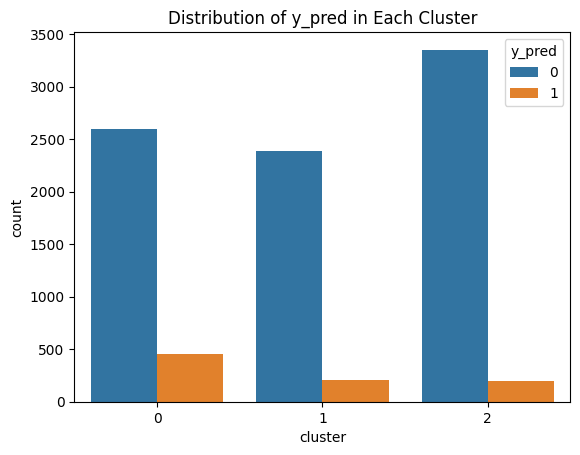

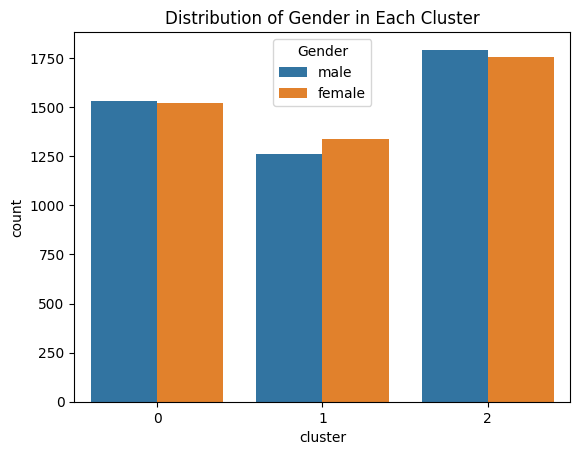

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the total counts for each cluster
cluster_counts = df_test_results['cluster'].value_counts()

sns.countplot(x='cluster', hue='y_pred', data=df_test_results)
plt.title('Distribution of y_pred in Each Cluster')
plt.show()

# Plot the distribution of 'Gender' for each cluster in percentage
sns.countplot(x='cluster', hue='Gender', data=df_test_results)
plt.title('Distribution of Gender in Each Cluster')
plt.show()


In [85]:
X['y_pred'] = y_pred_blackbox_test
df_cluster1 = X[X['cluster']==0]
df_cluster2 = X[X['cluster']==1]
df_cluster3 = X[X['cluster']==2]



In [88]:
df_cluster1.Gender.value_counts()

Gender
0    1335
1    1260
Name: count, dtype: int64

In [92]:
def count_gender_type(df):
    df_male = df[df['Gender'] == 0]
    df_female = df[df['Gender'] == 1]
    n1m = df_male[df_male['y_pred']==1].shape[0]
    n0m = df_male[df_male['y_pred']==0].shape[0]
    n1f = df_female[df_female['y_pred']==1].shape[0]
    n0f = df_female[df_female['y_pred']==0].shape[0]
    return n1f, n0f, n1m, n0m

def compute_expectations(df):
    n1f, n0f, n1m, n0m = count_gender_type(df)
    n = df.shape[0]
    nf = n1f+n0f
    nm = n1m+n0m
    n1 = n1f+n1m
    n0 = n0f+n0m

    E1f = nf*n1/n
    E0f = n0f*n0/n
    
    E1m = nm*n1/n
    E0m = nm*n0/n
    return E1f, E0f, E1m, E0m

def compute_test_statistic(df): 
    n1f, n0f, n1m, n0m = count_gender_type(df)
    E1f, E0f, E1m, E0m = compute_expectations(df)
    chi2 = (n1f - E1f)**2 / E1f + (n0f - E0f)**2 / E0f + (n1m - E1m)**2 / E1m + (n0m - E0m)**2 / E0m 
    return chi2


chi2_cluster1 = compute_test_statistic(df_cluster1)
print("Test statistic value for cluster 1: ", chi2_cluster1)

chi2_cluster2 = compute_test_statistic(df_cluster2)
print("Test statistic value for cluster 2: ", chi2_cluster2)

chi2_cluster3 = compute_test_statistic(df_cluster3)
print("Test statistic value for cluster 3: ", chi2_cluster3)

print("Total chi :", chi2_cluster1+chi2_cluster2+chi2_cluster3)

Test statistic value for cluster 1:  63.54170277213671
Test statistic value for cluster 2:  61.95934636022599
Test statistic value for cluster 3:  105.5712318758792
Total chi : 231.07228100824193


$\chi^2_{cluster1} = 63.54$

$\chi^2_{cluster2} = 61.96$

$\chi^2_{cluster3} = 05.57$

$\chi^2_{CSP, genre} = 231.07$

In [93]:
from scipy.stats import chi2

# Spécifiez le niveau de signification alpha et les degrés de liberté S
alpha = 0.05
S = 3  # Remplacez ceci par le nombre réel de degrés de liberté

# Calculez la valeur de chi2_{1-alpha, S}
chi2_1_minus_alpha_S = chi2.ppf(1 - alpha, df=S)

print(f"La valeur de chi2_{{1-alpha, {S}}} est : {chi2_1_minus_alpha_S}")


La valeur de chi2_{1-alpha, 3} est : 7.814727903251179


The null hypothesis is therefore rejected, and the model is biased.
Now let's look at what we get for ethnic groups.

In [96]:
df_cluster1.EthnicGroup.value_counts()

EthnicGroup
2    945
3    635
1    477
4    353
0    185
Name: count, dtype: int64

In [98]:
def count_EthnicGroup_type(df):

    df_A = df[df['EthnicGroup'] == 0]
    df_B = df[df['EthnicGroup'] == 1]
    df_C = df[df['EthnicGroup'] == 2]
    df_D = df[df['EthnicGroup'] == 3]
    df_E = df[df['EthnicGroup'] == 4]

    n1A = df_A[df_A['y_pred']==1].shape[0]
    n1B = df_B[df_B['y_pred']==1].shape[0]
    n1C = df_C[df_C['y_pred']==1].shape[0]
    n1D = df_D[df_D['y_pred']==1].shape[0]
    n1E = df_E[df_E['y_pred']==1].shape[0]

    n0A = df_A[df_A['y_pred']==0].shape[0]
    n0B = df_B[df_B['y_pred']==0].shape[0]
    n0C = df_C[df_C['y_pred']==0].shape[0]
    n0D = df_D[df_D['y_pred']==0].shape[0]
    n0E = df_E[df_E['y_pred']==0].shape[0]

    return n1A, n1B, n1C, n1D, n1E, n0A, n0B, n0C, n0D, n0E

def compute_expectations_EthnicGroup(df):
    n1A, n1B, n1C, n1D, n1E, n0A, n0B, n0C, n0D, n0E = count_EthnicGroup_type(df)
    n = df.shape[0]

    nA = n1A+n0A
    nB = n1B+n0B
    nC = n1C+n0C
    nD = n1D+n0D
    nE = n1E+n0E

    n1 = n1A+n1B+n1C+n1D+n1E
    n0 = n0A+n0B+n0C+n0D+n0E

    E1A = nA*n1/n
    E1B = nB*n1/n
    E1C = nC*n1/n
    E1D = nD*n1/n
    E1E = nE*n1/n

    E0A = nA*n0/n
    E0B = nB*n0/n
    E0C = nC*n0/n
    E0D = nD*n0/n
    E0E = nE*n0/n

    return E1A, E1B, E1C, E1D, E1E, E0A, E0B, E0C, E0D, E0E

def compute_test_statistic_ethnicgroup(df): 
    n1A, n1B, n1C, n1D, n1E, n0A, n0B, n0C, n0D, n0E = count_EthnicGroup_type(df)
    E1A, E1B, E1C, E1D, E1E, E0A, E0B, E0C, E0D, E0E = compute_expectations_EthnicGroup(df)

    termA1 = (n1A - E1A)**2 / E1A
    termB1 = (n1B - E1B)**2 / E1B
    termC1 = (n1C - E1C)**2 / E1C
    termD1 = (n1D - E1D)**2 / E1D
    termE1 = (n1E - E1E)**2 / E1E

    termA0 = (n0A - E0A)**2 / E0A
    termB0 = (n0B - E0B)**2 / E0B
    termC0 = (n0C - E0C)**2 / E0C
    termD0 = (n0D - E0D)**2 / E0D
    termE0 = (n0E - E0E)**2 / E0E
 
    chi2 = termA1 + termB1 + termC1 + termD1 + termE1 + termA0 + termB0 + termC0 + termD0 + termE0
    return chi2

chi2_cluster1 = compute_test_statistic_ethnicgroup(df_cluster1)
print("Test statistic value for cluster 1: ", chi2_cluster1)

chi2_cluster2 = compute_test_statistic_ethnicgroup(df_cluster2)
print("Test statistic value for cluster 2: ", chi2_cluster2)

chi2_cluster3 = compute_test_statistic_ethnicgroup(df_cluster3)
print("Test statistic value for cluster 3: ", chi2_cluster3)

print("Total chi :", chi2_cluster1+chi2_cluster2+chi2_cluster3)


Test statistic value for cluster 1:  148.68075468876714
Test statistic value for cluster 2:  410.3579129515436
Test statistic value for cluster 3:  215.57557874568718
Total chi : 774.6142463859978


$\chi^2_{cluster1} = 148.68$

$\chi^2_{cluster2} = 410.36$

$\chi^2_{cluster3} = 215.58$

$\chi^2_{CSP, ethnic} = 774.61$

Again : rejected hypothesis.